In [1]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from torchmetrics import Accuracy

RANDOM_SEED = 42
BATCH_SIZE = 32
EPOCHS = 3
LEARNING_RATE = 0.1
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(f'Device used: {DEVICE}')

torch.manual_seed = RANDOM_SEED
if torch.cuda.is_available():
    torch.cuda.manual_seed = RANDOM_SEED

Device used: cuda


In [55]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

classes = train_data.classes
print(f'Number of training images: {len(train_data)} | Number of test images: {len(test_data)}')

Number of training images: 60000 | Number of test images: 10000


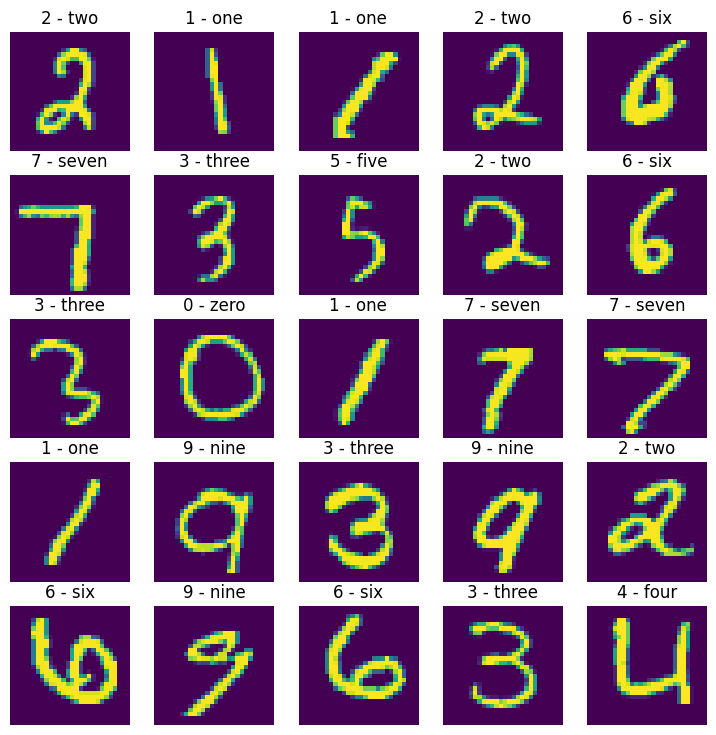

In [3]:
figure = plt.figure(figsize=(9,9))
rows, cols = 5, 5
for i in range(1, rows*cols+1):
    random_id = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_id]
    figure.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze())
    plt.title(classes[label])
    plt.axis(False)

In [62]:
train_dataloader = DataLoader(
    train_data,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataloader = DataLoader(
    test_data,
    batch_size=BATCH_SIZE,
    shuffle=False
)

In [5]:
def ConvBlock(in_channels, out_channels, kernel_size=3, stride=1, padding='same'):
    return nn.Sequential(
        nn.Conv2d(in_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.Conv2d(out_channels, out_channels, kernel_size, stride, padding),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=1)
    )

In [42]:
class CNN(nn.Module):
    def __init__(self, in_channels, out_channels, n_features, kernel_size=3, stride=1, padding='same'):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels, n_features, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(n_features, n_features, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(n_features, n_features, kernel_size, stride, padding),
            nn.ReLU(),
            nn.Conv2d(n_features, n_features, kernel_size, stride, padding),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=n_features*7*7,
                      out_features=out_channels)
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        x = self.classifier(x)
        return x

    def predict(self, x):
        self.eval()
        with torch.inference_mode():
            return self.forward(x)

In [43]:
model = CNN(
    in_channels=1,
    out_channels=len(classes),
    n_features=10
).to(DEVICE)

loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
accuracy_fn = Accuracy(
    task='multiclass',
    num_classes=len(classes),    
).to(DEVICE)

In [8]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = DEVICE):
    train_loss, train_acc = 0, 0

    for X, y in data_loader:
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)

        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f'Train loss: {train_loss} | Train accuracy: {train_acc}')

def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = DEVICE):
    test_loss, test_acc = 0, 0
    model.eval()

    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)

            y_pred = model(X)

            test_loss += loss_fn(y_pred, y)
            test_acc += accuracy_fn(y_pred.argmax(dim=1), y)

        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f'Test loss: {test_loss} | Test accuracy: {test_acc}')


In [44]:
from timeit import default_timer as timer
start_time = timer()

for epoch in range(EPOCHS):
    print(f'Epoch: {epoch+1}\n------------------------------')
    train_step(
        model=model,
        data_loader=train_dataloader,
        loss_fn=loss_fn,
        optimizer=optimizer,
        accuracy_fn=accuracy_fn
    )
    test_step(
        model=model,
        data_loader=test_dataloader,
        loss_fn=loss_fn,
        accuracy_fn=accuracy_fn
    )

end_time = timer()
print(f'Total train time on {DEVICE}: {end_time - start_time} seconds')

Epoch: 1
------------------------------
Train loss: 0.32221129536628723 | Train accuracy: 0.8911666870117188
Test loss: 0.06887905299663544 | Test accuracy: 0.9777355790138245
Epoch: 2
------------------------------
Train loss: 0.07639942318201065 | Train accuracy: 0.9765166640281677
Test loss: 0.0543074868619442 | Test accuracy: 0.983526349067688
Epoch: 3
------------------------------
Train loss: 0.06172824651002884 | Train accuracy: 0.9806666970252991
Test loss: 0.04481454938650131 | Test accuracy: 0.9858226776123047
Total train time on cuda: 46.45919200000003 seconds


In [47]:
def make_predictions(model: torch.nn.Module, data: list, device: torch.device = DEVICE):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            # Prepare sample
            sample = torch.unsqueeze(sample, dim=0).to(device) # Add an extra dimension and send sample to device

            # Forward pass (model outputs raw logit)
            pred_logit = model(sample)

            # Get prediction probability (logit -> prediction probability)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)

            # Get pred_prob off GPU for further calculations
            pred_probs.append(pred_prob.cpu())
            
    # Stack the pred_probs to turn list into a tensor
    return torch.stack(pred_probs)

In [48]:
import random
random.seed(42)
test_samples = []
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

# View the first test sample shape and label
print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({classes[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 2 (2 - two)


In [49]:
pred_probs= make_predictions(model=model, 
                             data=test_samples)
pred_classes = pred_probs.argmax(dim=1)

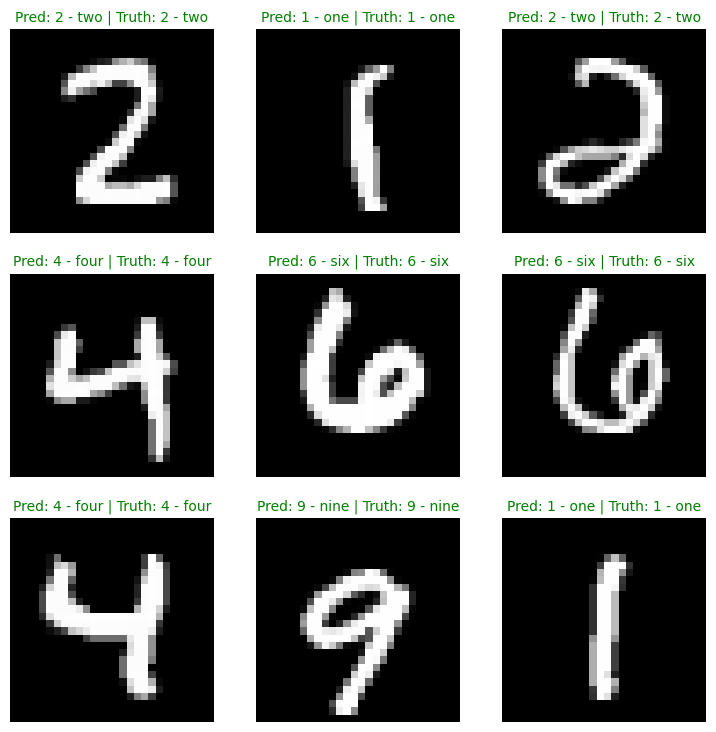

In [50]:
# Plot predictions
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  # Create a subplot
  plt.subplot(nrows, ncols, i+1)

  # Plot the target image
  plt.imshow(sample.squeeze(), cmap="gray")

  # Find the prediction label (in text form, e.g. "Sandal")
  pred_label = classes[pred_classes[i]]

  # Get the truth label (in text form, e.g. "T-shirt")
  truth_label = classes[test_labels[i]] 

  # Create the title text of the plot
  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  # Check for equality and change title colour accordingly
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g") # green text if correct
  else:
      plt.title(title_text, fontsize=10, c="r") # red text if wrong
  plt.axis(False);

In [67]:
y_preds = []
model.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        X, y = X.to(DEVICE), y.to(DEVICE)
        y_logit = model(X)
        y_pred = torch.softmax(y_logit.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred)

y_preds_tensor = torch.cat(y_preds)

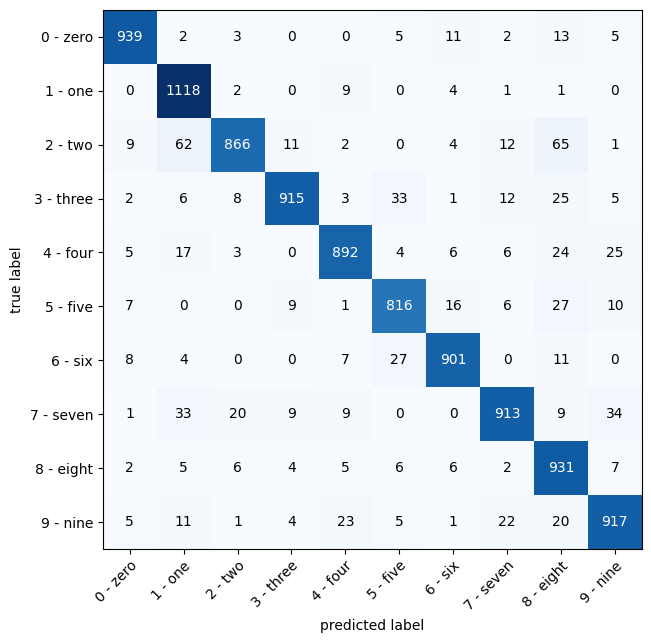

In [69]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(task="multiclass", num_classes=len(classes)).to(DEVICE)
confmat_tensor = confmat(preds=y_preds_tensor.to(DEVICE),
                         target=test_data.targets.to(DEVICE)).to(DEVICE)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.cpu().numpy(),
    class_names=classes,
    figsize=(10,7)
)
